# **coffea** - Columnar Object Framework For Effective Analysis

Basic tools and wrappers for enabling not-too-alien syntax when running columnar Collider HEP analysis.

[coffea](https://coffeateam.github.io/coffea/index.html) is a prototype package for pulling together all the typical needs of a high-energy collider physics (HEP) experiment analysis using the scientific python ecosystem. It makes use of [uproot](https://github.com/scikit-hep/uproot4) and [awkward-array](https://github.com/scikit-hep/awkward) to provide an **array-based syntax** for `manipulating HEP event` data in an efficient and numpythonic way. There are sub-packages that `implement histogramming`, plotting, and `look-up table functionalities` that are needed to convey scientific insight, apply transformations to data, and correct for discrepancies in Monte Carlo simulations compared to data.

coffea also supplies facilities for horizontally scaling an analysis in order to reduce time-to-insight in a way that is largely independent of the resource the analysis is being executed on. By making use of modern big-data technologies like [Apache Spark](https://spark.apache.org/), [parsl](https://github.com/Parsl/parsl), [Dask](https://dask.org/), and [Work Queue](http://ccl.cse.nd.edu/software/workqueue), it is possible with coffea to **scale a HEP analysis to**: 
- a large multi-core server,
- computing clusters,
- super-computers.

# Reading data with coffea NanoEvents

**NanoEvents** is a Coffea utility to wrap flat nTuple structures (such as the CMS [NanoAOD](https://www.epj-conferences.org/articles/epjconf/pdf/2019/19/epjconf_chep2018_06021.pdf) format) into a single awkward array with appropriate object methods (such as Lorentz vector methods), cross references, and nested objects, all lazily accessed $^\dagger$ from the source ROOT TTree via uproot.

The interpretation of the **TTree data is configurable via [schema objects](https://coffeateam.github.io/coffea/modules/coffea.nanoevents.html#classes)**, which are community-supplied  for various source file types. These **schema objects allow a richer interpretation of the file contents** than the [uproot.lazy](https://uproot4.readthedocs.io/en/latest/uproot4.behaviors.TBranch.lazy.html) methods. Currently available schemas include:

   - **`BaseSchema`, which provides a simple representation of the input TTree**, where each branch is available verbatim as `events.branch_name`, effectively the same behavior as `uproot.lazy`.  Any branches that uproot supports at "full speed" (i.e. that are fully split and either flat or single-jagged) can be read by this schema;
   - **`NanoAODSchema`, which is optimized to provide all methods and cross-references in CMS NanoAOD format**;
   - `PFNanoAODSchema`, which builds a double-jagged particle flow candidate colllection `events.jet.constituents` from compatible PFNanoAOD input files;
   - `TreeMakerSchema` which is designed to read TTrees made by [TreeMaker](https://github.com/TreeMaker/TreeMaker), an alternative CMS nTuplization format;
   - `PHYSLITESchema`, for the ATLAS DAOD_PHYSLITE derivation, a compact centrally-produced data format similar to CMS NanoAOD; and
   - `DelphesSchema`, for reading Delphes fast simulation [nTuples](https://cp3.irmp.ucl.ac.be/projects/delphes/wiki/WorkBook/RootTreeDescription).


$^\dagger$ _Lazy_ access refers to only fetching the needed data from the (possibly remote) file when a sub-array is first accessed. The sub-array is then _materialized_ and subsequent access of the sub-array uses a cached value in memory. As such, fully materializing a `NanoEvents` object may require a significant amount of memory.


In this tutorial, we will use `NanoEvents` to read several CMS NanoAOD files and perform a simple analysis to **plot the diphoton mass**.

## Load a root file from gluon-gluon fusion $H \rightarrow \gamma \gamma$

In [1]:
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fname = "/eos/cms/store/group/phys_higgs/cmshgg/tutorials/HiggsDNA_FinalFits_2024/HiggsDNA_part/01_intro/ggh_M-125_preEE/5d677ef6-111a-428f-a78c-7ae0f68fd140.root"

events = NanoEventsFactory.from_root(fname,schemaclass=NanoAODSchema).events()

### Check the content

In [2]:
# fields of events
print(events.fields)

# subfields of the events, e.g., Photon collection fields
print(events.Photon.fields)

# are you able to print out the Electron collection fields?


['Flag', 'TrigObj', 'LHEWeight', 'Rho', 'LHEPart', 'ChsMET', 'LHE', 'DST', 'GenMET', 'HLTriggerFinalPath', 'Dataset', 'DeepMETResolutionTune', 'LHEReweightingWeight', 'PSWeight', 'OtherPV', 'GenJet', 'CorrT1METJet', 'SoftActivityJetNjets10', 'LowPtElectron', 'PuppiMET', 'MC', 'GenDressedLepton', 'GenPart', 'GenJetAK8', 'DeepMETResponseTune', 'SoftActivityJetNjets5', 'SoftActivityJetNjets2', 'TkMET', 'SoftActivityJet', 'L1simulation', 'SubJet', 'SoftActivityJetHT', 'bunchCrossing', 'MET', 'HLT', 'CaloMET', 'run', 'RawMET', 'FatJet', 'FsrPhoton', 'Pileup', 'RawPuppiMET', 'HLTriggerFirstPath', 'Photon', 'GenIsolatedPhoton', 'Electron', 'Muon', 'PV', 'SV', 'Generator', 'GenProton', 'SubGenJetAK8', 'HTXS', 'SoftActivityJetHT10', 'GenVtx', 'L1', 'boostedTau', 'Tau', 'L1Reco', 'LHEScaleWeight', 'luminosityBlock', 'SoftActivityJetHT5', 'TauProd', 'IsoTrack', 'genTtbarId', 'event', 'BeamSpot', 'GenVisTau', 'genWeight', 'LHEPdfWeight', 'Jet', 'SoftActivityJetHT2']
['seediEtaOriX', 'cutBased', 'e

In [3]:
# find the Photon pt for the frist three events
ak.to_list(events.Photon.pt[:3])

[[24.54996109008789, 12.523418426513672],
 [66.98872375488281],
 [104.02416229248047, 33.340904235839844]]

### Get the photon collection

In [4]:
photons = events.Photon

### Add some selections

In [5]:
count_number_of_photons = ak.num(photons,axis=1)

In [6]:
# The number of photons of each event is not one fixed value, e.g.,
ak.to_list(count_number_of_photons[19202:19210])

[2, 2, 1, 2, 2, 2, 3, 1]

In [7]:
# we only want events with more than one photon
# we can mask events without at least two photons
photons_masked = photons.mask[count_number_of_photons > 1]

# you can check what count_number_of_photons > 1 is:
# ak.to_list(count_number_of_photons > 1)

In [8]:
# check what happened for events with one photon 
ak.to_list(photons_masked.pt[19202:19210])

[[60.28999328613281, 46.929622650146484],
 [74.58683776855469, 62.25569534301758],
 None,
 [57.518497467041016, 45.884681701660156],
 [60.75871276855469, 53.41633224487305],
 [43.256378173828125, 41.31281280517578],
 [79.43109893798828, 51.122013092041016, 36.38378143310547],
 None]

In [ ]:
# signal events usually have energetic photons, but some backgrounds might have misidentified photons with lower energy.
# E.g., misidentified photons from jets
# So we also applied some kenimatic selections for photon, e.g., leading Photon pt > 35 GeV, subleading Photon pt > 20 GeV

photons_masked = photons_masked.mask[
    (photons_masked.pt[:,0] > 35) &
    (photons_masked.pt[:,1] > 25)
]

# Question: Why are the brackets () necessary here? What happens if you request
# photons_masked = photons_masked.mask[
#     photons_masked.pt[:,0] > 35 &
#    (photons_masked.pt[:,1] > 25
#]
# Why?

In [10]:
# now only keep the events with more than one photon
total_selection = ak.fill_none(
    ak.num(photons_masked,axis=1) > 0,
    False
)

photons_selected = photons_masked[total_selection]

In [11]:
# what's the difference between: photons, photons_masked, and photons_selected?

# print("\n",
#     "Length of photons:", len(photons), "\n",
#     "Length of photons_masked:", len(photons_masked), "\n",
#     "Length of photons_selected:", len(photons_selected)     
# )

### Get diphoton pairs

Use `ak.combinations` to create diphoton pairs. The `ak.combinations` computes a Cartesian product (i.e. cross product) of array with itself that is restricted to combinations sampled without replacement.

![Tux, the Linux mascot](cartoon-combinations.png)

In [12]:
# add charge varibale to the photons. It will be used in the diphoton 4-momentum calculation
photons_selected["charge"] = ak.zeros_like(photons_selected.pt)

# make diphoton combinations
diphoton_pairs = ak.combinations(photons_selected, 2, fields=["lead", "sublead"])

In [13]:
# Can you print out the pt of the lead/sublead photon in the diphoton pairs

# ak.to_list(diphoton_pairs.lead.pt[19202:19210])

### diphoton four-momentum

In [14]:
diphotons = diphoton_pairs.lead+diphoton_pairs.sublead

In [15]:
# we usually consider the diphoton object with the largest sum of the lead and sublead photon pt
# photons_selected are ordered by their pt from largest to smallest
# so we only care about the leading diphoton object in this tutorial

diphotons.mass[:,0]

<Array [123, 121, 126, 126, ... 123, 128, 125] type='633991 * ?float32'>

### Make diphoton mass plot

We will use the following packages for making plots. 
- [Hist](https://hist.readthedocs.io/en/latest/): a powerful Histogramming tool for analysis based on boost-histogram (the Python binding of the Histogram library in Boost)
- [mplhep](https://mplhep.readthedocs.io/en/latest/): A matplotlib wrapper for easy plotting required in high energy physics (HEP)

In [16]:
import hist
from hist import Hist

# define the histogram
h = (
    Hist.new.Reg(100, 100, 150, overflow=False, underflow=False, name=r"m$_{\gamma \gamma}$ [GeV]")
    .Weight()
)

# fill diphoton mass
h.fill(diphotons.mass[:,0])

Hist(Regular(100, 100, 150, underflow=False, overflow=False, name='m$_{\\gamma \\gamma}$ [GeV]'), storage=Weight()) # Sum: WeightedSum(value=605728, variance=605728)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd3a5954040>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

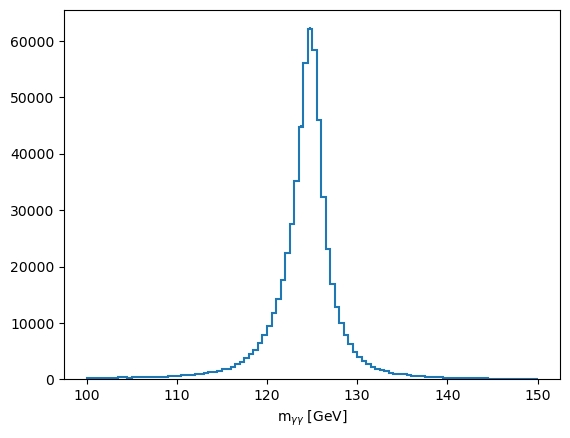

In [17]:
h.plot()

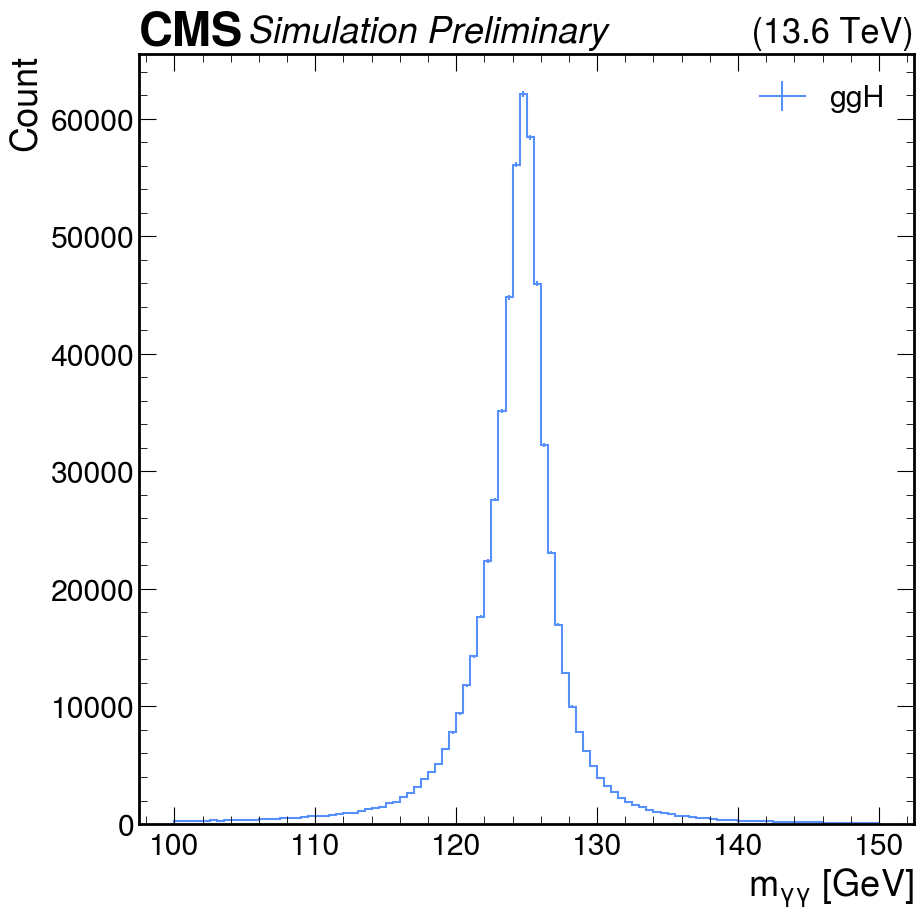

In [18]:
# format plot with mplhep

import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.CMS)

f, ax = plt.subplots(figsize=(10,10))

ax.set_ylabel("Count")
h.plot(ax=ax,label="ggH")

hep.cms.label("Preliminary",loc=0,com=13.6)

plt.legend()
plt.show()

# Coffea Processors

Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done **to build a parallelized framework** to process the data in a reasonable amount of time. 

Coffea provides the `coffea.processor` module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

 * A `ProcessorABC` abstract base class that can be derived from to implement the analysis code;
 * A [NanoEvents](https://coffeateam.github.io/coffea/notebooks/nanoevents.html) interface to the arrays being read from the TTree as inputs;
 * A generic `accumulate()` utility to reduce the outputs to a single result, as showin in the accumulators notebook tutorial; and
 * A set of parallel executors to access multicore processing or distributed computing systems such as [Dask](https://distributed.dask.org/en/latest/), [Parsl](http://parsl-project.org/), [Spark](https://spark.apache.org/), [WorkQueue](https://cctools.readthedocs.io/en/latest/work_queue/), and others.

Let's start by writing a simple processor class that reads NanoAOD root files and plots a diphoton mass spectrum.
We'll start by copying the [ProcessorABC](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton:

```
from coffea import hist, processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self, flag=False):
        self._flag = flag

    def process(self, events):
        out = {"sumw": ak.num(events, axis=0)}

        # ...

        return {events.metadata.dataset: out}

    def postprocess(self, accumulator):
        pass

p = MyProcessor()
```


and filling in some details:

 * Remove `flag`, as we won't use it
 * Adding a new histogram for $m_{\gamma \gamma}$
 * Reading the files with `NanoAODSchema`
 * Building a [Candidate](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate.html#coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate) record for diphotons
 * Calculating the diphoton invariant mass

In [24]:
from coffea import processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass


    def process(self, events):
        dataset = events.metadata["dataset"]

        # define the histogram
        results={}
        results[dataset]={
            "count": len(events)
        }
            
        h = (
            Hist.new.StrCat([], growth=True, name="dataset", label="Primary dataset")
            .Reg(100, 100, 150, overflow=False, underflow=False, name="x", label = r"m$_{\gamma \gamma}$ [GeV]")
            .Weight()
        )

        # get photons
        photons = events.Photon


        # add selections
        count_number_of_photons = ak.num(photons, axis=1)

        photons_masked = photons.mask[count_number_of_photons > 1]
        photons_masked = photons_masked.mask[
            (photons_masked.pt[:,0] > 35) &
            (photons_masked.pt[:,1] > 25)
        ]

        # save only the events pass the selections
        total_selection = ak.fill_none(
            ak.num(photons_masked,axis=1) > 0,
            False
        )

        photons_selected = photons_masked[total_selection]

        # make the diphoton pair combinations
        photons_selected["charge"] = ak.zeros_like(photons_selected.pt)
        diphoton_pairs = ak.combinations(photons_selected, 2, fields=["lead", "sublead"])

        # diphoton four-momentum
        diphotons = diphoton_pairs.lead+diphoton_pairs.sublead

        h.fill(dataset=dataset,x=diphotons.mass[:,0])


        results["mass"] = h
        return results

    def postprocess(self, accumulant):
        pass


### Process the datasets with `MyProcessor`

In [20]:
# define the sample dictionary
# we add a file for ggH and another for DY
sample_dict = {
    "ggH":[
        "/eos/cms/store/group/phys_higgs/cmshgg/tutorials/HiggsDNA_FinalFits_2024/HiggsDNA_part/01_intro/ggh_M-125_preEE/5d677ef6-111a-428f-a78c-7ae0f68fd140.root"
    ],
    "DY": [
        "/eos/cms/store/group/phys_higgs/cmshgg/tutorials/HiggsDNA_FinalFits_2024/HiggsDNA_part/02_03_TnP/DY/00b15860-be57-4739-af70-48a73faa0161.root"
    ]
}

In [25]:
run = processor.Runner(
    # executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(workers=4), # user 4 cores
    schema=NanoAODSchema
)

results = run(
    sample_dict,
    treename="Events",
    processor_instance=MyProcessor(),
)



Output()

In [26]:
results

{'DY': {'count': 143657},
 'mass': Hist(
   StrCategory(['DY', 'ggH'], growth=True, name='dataset', label='Primary dataset'),
   Regular(100, 100, 150, underflow=False, overflow=False, name='x', label='m$_{\\gamma \\gamma}$ [GeV]'),
   storage=Weight()) # Sum: WeightedSum(value=607073, variance=607073),
 'ggH': {'count': 918697}}

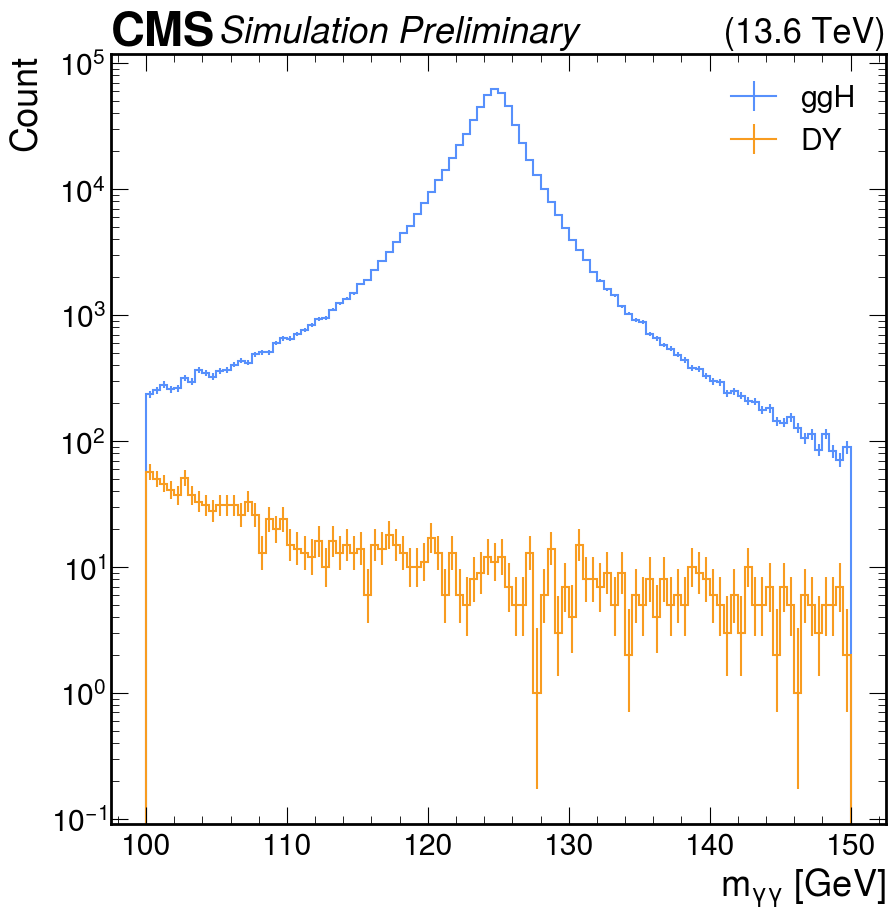

In [32]:
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.CMS)

f, ax = plt.subplots(figsize=(10,10))

ax.set_ylabel("Count")
results["mass"][{"dataset":"ggH"}].plot(ax=ax,label="ggH")
results["mass"][{"dataset":"DY"}].plot(ax=ax,label="DY")

hep.cms.label("Preliminary",loc=0,com=13.6)

ax.set_yscale("log")
plt.legend()
plt.show()

# Bonus: Applying corrections to columnar data

# Systematics: S+S Weights, Pileup, implement one weight syst?

### one task to compare before and after correction, e.g., S+S